In [40]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [43]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [44]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74
#for i, scale in enumerate(np.linspace(0.85, 1.45, 13)):
#    print(round(reos[i], 3), universal_eos(scale, 'W'))

In [45]:
with open(os.path.join(working, 'stats_clean'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_clean'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [46]:
#print(len(targ_ready['md']['energy']))
[(i, r) for i, r in enumerate(stats_ready['hyperparams'])]

[(0, 2.4),
 (1, 2.45),
 (2, 2.5),
 (3, 2.65),
 (4, 2.7),
 (5, 2.72),
 (6, 2.73),
 (7, 2.74),
 (8, 2.75),
 (9, 2.77),
 (10, 2.8),
 (11, 2.85),
 (12, 2.9),
 (13, 3.0),
 (14, 3.1),
 (15, 3.2),
 (16, 3.3),
 (17, 3.45),
 (18, 3.6),
 (19, 3.75),
 (20, 4.0),
 (21, 4.1),
 (22, 4.25),
 (23, 4.356),
 (24, 4.5),
 (25, 4.65),
 (26, 4.8),
 (27, 5.0),
 (28, 5.15),
 (29, 5.3),
 (30, 5.45),
 (31, 5.6),
 (32, 5.75)]

In [47]:
#2.5  2.75 3.   3.5  4.   4.5  5.   5.75
#2.65 2.75 3.25 3.75 4.25 4.75 5.25 5.75
#2.65 2.7 2.75 2.8 3.25 3.75 4.25 4.75 5.25 5.75

#2.5  2.7 2.75 2.85 3. 3.5  4.   4.5  5.   5.75

multi_index = []
#multi_index.append([1, 3, 6, 8, 10, 12, 14, 16])
#multi_index.append([0, 3, 5, 8, 13, 17, 20, 24, 27, 31])
multi_index.append([2, 4, 8, 11, 13, 17, 20, 24, 27, 32])
multi_index.append([1, 4, 6, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([1, 4, 7, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([1, 5, 8, 12, 14, 18, 22, 26, 31])
multi_index.append([1, 6, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([2, 8, 13, 17, 20, 24, 27, 32])

In [48]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.5  2.7  2.75 2.85 3.   3.45 4.   4.5  5.   5.75]
[2.45 2.7  2.73 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.45 2.7  2.74 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.45 2.72 2.75 2.9  3.1  3.6  4.25 4.8  5.6 ]
[2.45 2.73 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.5  2.75 3.   3.45 4.   4.5  5.   5.75]


In [49]:
stats_opts[0]['md']['energy'][-1]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [50]:
#uend = stats_opts[0]['md']['energy'][-1]
#fend = stats_opts[0]['md']['forces'][-1]
#utar = targ_ready['md']['energy'][-1]
#ftar = targ_ready['md']['forces'][-1]

In [51]:
#for i in range(2000):
#    stats_opts[0]['md']['energy'].append(uend)
#    stats_opts[0]['md']['forces'].append(fend)
#    targ_ready['md']['energy'].append(utar)
#    targ_ready['md']['forces'].append(ftar)

In [52]:
#pars_dict['pair'] = [-28.301652628205268, -0.0022071786576090694, 0.027656591839734557, -6.543090393280296, 10.102407371395133, -2.478121982724172, 3.7048200337887582, -3.6346043391919514, 1.7181534576100437, -0.2520201994640249]
#pars_dict['embed'] = [-1.1825596913794016, 2.8944059727957714e-05]
pars_list = []
for index in multi_index:
    pars_dict = {}
    if len(np.array(stats_ready['hyperparams'])[index]) == 10:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 0.0, 2.30194161e+01, 0.0, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]
    elif len(np.array(stats_ready['hyperparams'])[index]) == 9:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 0.0, 2.30194161e+01, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]        
    elif len(np.array(stats_ready['hyperparams'])[index]) == 8:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 2.30194161e+01, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]        
    else:
        raise ValueError('Unsupported number of parameters')
    print(len(np.array(stats_ready['hyperparams'])[index]), len(pars_dict['pair']))
    pars_list.append(pars_dict)

with open(os.path.join(working, "pars_in.pickle"), 'wb') as fo:
    pickle.dump(pars_list, fo)


10 10
10 10
10 10
9 9
9 9
8 8


In [53]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_list = pickle.load(fi)
print(pars_list)

[{'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}]


In [54]:
it = 0 # read in it (independent process)
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [55]:
pars_dict = pars_list[it]
pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in, len(pars_in))

[-0.684229349, 0.000152487644, -65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974] 12


In [69]:
target[0]['weight'] = 1.0
target[1]['weight'] = 2.0
target[2]['weight'] = 0.5
target[3]['weight'] = 1.0
target[4]['weight'] = 0.8

In [70]:
len(target[0]['energy']), [t['weight'] for t in target], target[1]['energy']

(1284,
 [1.0, 2.0, 0.5, 1.0, 0.8],
 [-1139.2,
  -906.9778906249999,
  -1127.13044453125,
  -1136.3561554687499,
  -1136.7059554687498,
  0.0,
  0.0])

In [71]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=3):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
    #print(optimal_parameters)
                 
    best_params = sorted(optimal_parameters, key=lambda param: param[0])[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [74]:
multi_pars = []

multi_pars.append([ 4.21813176e+00,  1.28438711e-02,  7.18447209e+02,  2.79873504e+01,
       -3.64063120e+01,  1.55668343e+01, -3.59671207e+00,  7.18079901e-02,
       -7.56657066e-02,  2.53180527e-01, -4.96952030e-01, -4.27379804e-02])

multi_pars.append([-1.70284536e+00,  1.77584742e-03, -2.03091714e+02,  6.67172987e+02,
       -1.39072153e+03,  7.95275451e+02, -2.44611978e+01,  5.09001525e+00,
       -3.57713253e-01, -1.04584266e+00,  1.30255105e+00, -4.09472026e-01])

multi_pars.append([ 1.49705729e+00,  8.14531512e-03, -8.15988329e+02,  5.87519886e+02,
       -1.01285873e+03,  5.10026120e+02, -1.11686150e+01,  1.51343754e+00,
        1.15612472e-01, -4.84858749e-01,  3.56870076e-01, -2.09915075e-01])

multi_pars.append([ 1.54864560e+00,  1.06062750e-02, -3.00996729e+02,  3.32437763e+02,
       -3.39714171e+02,  9.93126859e+01, -2.04873166e+01,  1.12932344e+00,
       -7.73962738e-02, -1.97622239e-01,  1.14699068e-01, -1.23093792e-01])

multi_pars.append([ 1.08153442e+00,  2.12340093e-03, -2.83828424e+02,  3.30196594e+02,
       -3.61260411e+02,  1.30278313e+02, -3.12845720e+01,  2.97822976e+00,
       -5.85372576e-02, -8.72679252e-01,  5.95310242e-01, -2.30722232e-01])

multi_pars.append([-1.84530425e+00, -2.18389467e-05, -1.46520729e+03,  1.16790147e+02,
       -1.41528209e+02,  7.82448301e+01,  4.04340173e+00, -2.96638562e+00,
        2.19448488e+00, -5.43928853e-01, -1.31154657e+00,  7.46848321e-01])

#multi_pars.append([-2.58497269e+00, -7.98482857e-05, -4.80522777e+00,  7.27769167e+01,
#       -9.08527121e+01,  5.22384962e+01, -1.30656472e+01,  1.20158643e+00,
#        2.92892542e-01, -7.51221013e-01,  1.29332724e-01,  1.79078212e-01])

#multi_pars.append([ 1.54864560e+00,  1.06062750e-02, -3.00996729e+02,  3.32437763e+02,
#       -3.39714171e+02,  9.93126859e+01, -2.04873166e+01,  1.12932344e+00,
#       -7.73962738e-02, -1.97622239e-01,  1.14699068e-01, -1.23093792e-01])

#multi_pars.append([ 8.13208315e-01,  7.37117140e-03, -8.19982975e+02,  6.16948045e+02,
#       -1.08159723e+03,  5.52647596e+02, -1.30505218e+01,  1.99300289e+00,
#        1.20773890e-01, -7.28007140e-01,  6.23374409e-01, -2.63144681e-01])

#multi_pars.append([-3.31561243e-01,  6.11880566e-03, -9.71792068e+02,  5.84785795e+02,
#       -9.70393918e+02,  4.80539429e+02, -1.19631593e+01,  1.74524655e+00,
#        1.30016634e+00, -2.17244459e+00,  1.54141798e+00, -4.27749577e-01])

#multi_pars.append([-1.94676818e+00, -1.00213528e-04, -7.50184465e+02,  4.02484931e+02,
#       -7.69176541e+02,  4.49109198e+02, -1.74942886e+01,  3.38385035e+00,
#        1.32669118e+00, -2.33887861e+00,  1.88569396e+00, -5.00674372e-01])

#multi_pars.append([ 1.28170537e+00,  5.73600852e-03, -1.22676678e+03,  1.37266450e+03,
#       -2.55956924e+03,  1.34512686e+03, -2.61927223e+01,  5.41221234e+00,
#       -3.14995466e+00,  2.23970362e+00, -8.25772384e-01, -2.23081195e-02])

#multi_pars.append([-2.88264157e+00, -1.29379757e-04, -7.63896489e+01,  0.0, 3.11940843e+01, 0.0,
#       -4.08372519e+00,  2.23147357e-01,  1.37384374e+00, -1.66367728e+00,
#        4.56398664e-01,  1.77978098e-01])

#multi_pars.append([-1.62881495e+00, -1.34430121e-05,  4.44435468e+01,  0.0, 1.44694307e+01, 0.0,
#        2.61563868e+00, -2.27083334e+00,  1.32643446e+00,  1.00353133e-01,
#       -1.29821366e+00,  5.47283066e-01])

#multi_pars.append(np.array(pars_in))

for _ in range(0):
    pars = np.array(multi_pars[0])
    pars += np.random.standard_normal(pars.shape)*0.4
    print(pars)
    multi_pars.append(pars)
    
for _ in range(0):
    pars = np.array(multi_pars[1])
    pars += np.random.standard_normal(pars.shape)*0.4
    print(pars)
    multi_pars.append(pars)
    
for _ in range(0):
    pars = np.array(multi_pars[2])
    pars += np.random.standard_normal(pars.shape)*0.4
    print(pars)
    multi_pars.append(pars)

for _ in range(0):
    pars = np.array(multi_pars[2])
    pars += np.random.standard_normal(pars.shape)*0.4
    print(pars)
    multi_pars.append(pars)

In [76]:
#multi_pars

In [77]:
#multi_pars = []

#multi_pars.append([ 4.21813176e+00,  1.28438711e-02,  7.18447209e+02,  2.79873504e+01,
#       -3.64063120e+01,  1.55668343e+01, -3.59671207e+00,  7.18079901e-02,
#       -7.56657066e-02,  2.53180527e-01, -4.96952030e-01, -4.27379804e-02])

In [87]:
for ieam in range(9, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    m_pars = multi_pars
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, m_pars, n_b=len(m_pars))
        m_pars = [p[1] for p in best_pars]

ieam: 9
0  sd2: ini 12.268686118726542

../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  eee = np.exp(-uuu)


sd2: final 12.268686118726542
1  sd2: ini 7.070137846263654sd2: final 0.19890564222409463
2  sd2: ini 12.268686118726542sd2: final 12.268686118726542
3  sd2: ini 12.268686118726542sd2: final 12.268686118726542
4  sd2: ini 7.229627474974159sd2: final 0.025698328725541595
5  sd2: ini 6.145767783254056sd2: final 0.008456119415979294
Best params: [(0.008456119415979294, array([-1.79249003e+00, -2.00331122e-05, -3.35312820e+01,  6.03345792e+01,
       -2.43444547e+01, -7.74532973e+00,  9.50962099e+00, -3.47822265e+00,
        1.68154006e+00,  7.65107568e-02, -1.43879186e+00,  6.14226236e-01])), (0.025698328725541595, array([ 1.24967079e-01,  8.39073429e-05, -1.58698729e+02,  3.52708043e+02,
       -4.19184447e+02,  1.51612646e+02, -3.25937129e+01,  3.26022576e+00,
       -7.53521755e-02, -1.18459793e+00,  9.11217336e-01, -2.83673203e-01])), (0.19890564222409463, array([ 2.52788705e-01, -8.22908094e-05,  1.27882600e+02,  5.38765234e+02,
       -6.70288054e+02,  2.42911562e+02, -5.16716247e+0

0  sd2: ini 0.007372937029177636sd2: final 0.007372839633041122
1  sd2: ini 0.007377250043624508

KeyboardInterrupt: 

In [31]:
ieam6 = (0.013029382935406411, np.array([ 1.54864560e+00,  1.06062750e-02, -3.00996729e+02,  3.32437763e+02,
       -3.39714171e+02,  9.93126859e+01, -2.04873166e+01,  1.12932344e+00,
       -7.73962738e-02, -1.97622239e-01,  1.14699068e-01, -1.23093792e-01]))

In [39]:
ieam7 = (0.020767854281604603, array([ 1.08153442e+00,  2.12340093e-03, -2.83828424e+02,  3.30196594e+02,
       -3.61260411e+02,  1.30278313e+02, -3.12845720e+01,  2.97822976e+00,
       -5.85372576e-02, -8.72679252e-01,  5.95310242e-01, -2.30722232e-01]))

In [80]:
ieam9 = (0.028572627723456062, np.array([-1.84530425e+00, -2.18389467e-05, -1.46520729e+03,  1.16790147e+02,
       -1.41528209e+02,  7.82448301e+01,  4.04340173e+00, -2.96638562e+00,
        2.19448488e+00, -5.43928853e-01, -1.31154657e+00,  7.46848321e-01]))

In [61]:
ieam8 = (0.02036416015408666, np.array([-2.58497269e+00, -7.98482857e-05, -4.80522777e+00,  7.27769167e+01,
       -9.08527121e+01,  5.22384962e+01, -1.30656472e+01,  1.20158643e+00,
        2.92892542e-01, -7.51221013e-01,  1.29332724e-01,  1.79078212e-01]))

In [80]:
ieam7 = (0.012953767988962356, np.array([ 2.30502222e+00,  3.07508489e-03, -2.41877118e+02,  2.21829913e+02,
       -2.34314206e+02,  8.22607076e+01, -2.27797233e+01,  2.08081663e+00,
       -2.29840971e-01, -5.74039990e-01,  3.65024960e-01, -2.49802378e-01]))

In [89]:
ieam9 = (0.007372937029177636, np.array([-1.48107607e+00, -2.11281591e-06, -7.75748552e+01,  1.23284902e+02,
       -1.05876828e+02,  2.56371829e+01,  7.21885424e-01, -2.01549825e+00,
        9.46930507e-01,  2.72867578e-01, -1.23624777e+00,  4.90853203e-01]))

In [54]:
optimal_parameters = [(4.407570269501649e-05, [-1.21658318e+00,  3.24863580e-05, -4.73661687e+01,  2.29965951e+01,
       -3.42248343e+00,  3.73956980e+00, -1.39292737e+00, -8.33458565e-01,
        9.29769431e-01, -1.83568989e-01]), (6.17447812420396e-05, [-1.30551487e+00,  1.41920657e-05, -4.61160967e+01,  2.29352328e+01,
       -3.42360958e+00,  3.82313395e+00, -1.54715703e+00, -6.97925842e-01,
        8.68730239e-01, -1.54592379e-01]), (9.723561709685708e-05, [-1.34624502e+00,  7.49457487e-06, -4.58871674e+01,  2.24064873e+01,
       -3.46516902e+00,  4.02263760e+00, -1.89661680e+00, -4.31617423e-01,
        8.06406324e-01, -1.37562101e-01]), (0.00014123622250142564, [-1.34136558e+00,  1.01769934e-05, -4.93998032e+01,  2.21279115e+01,
       -3.50791272e+00,  4.16822104e+00, -2.13414308e+00, -2.66237999e-01,
        7.83819577e-01, -1.36703203e-01])]

In [91]:
optimal_parameters = [ieam9]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1137.2972984084095, -920.2320122715646, -1131.886988787262, -1134.6331287872722, -1134.5133784481368]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
Model: [-1137.2972984084095, -920.2320122715646, -1131.886988787262, -1134.6331287872722, -1134.5133784481368]
0 0.007372937029177636


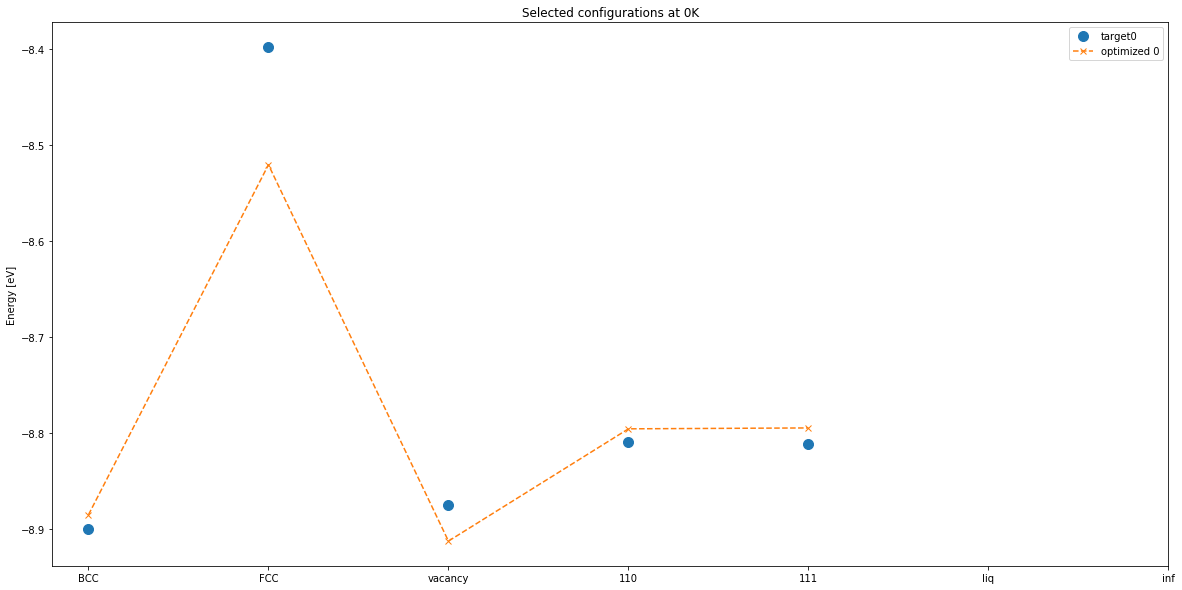

In [92]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-4][:-2])
        print('Model:', opti_out[-4][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-4][:-2]))/nat)
        plt.plot(np.array(targ_out[-4][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    print('Model:', opti_out[-4][:-2])

    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-4][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

8
Targ: [-1139.1553999999999, -1022.8066999999999, -1114.8183999999999, -1123.9361, -1084.6381, -1031.6408, -971.3192999999999, -907.6867, 0.0]
Model: [-1137.2972984084095, -1013.2667799608193, -1109.6975042896638, -1110.1637089502783, -1065.6107360982137, -1018.814625345392, -969.8076777143501, -916.2952939432921, 0.0]
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0 0.007372937029177636


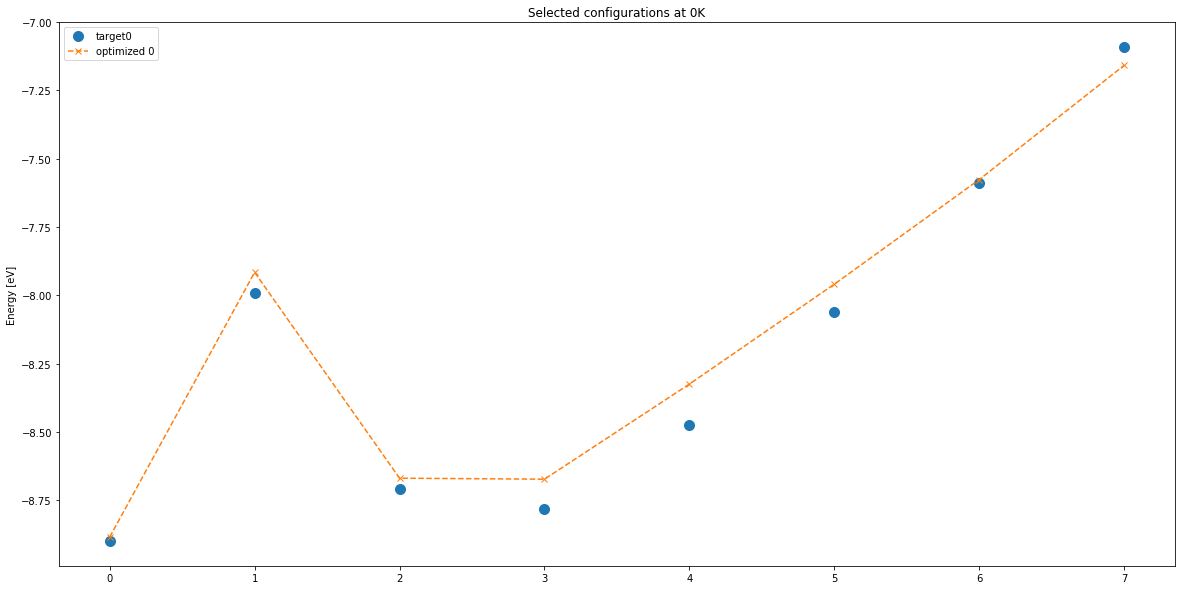

In [94]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_bcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:])
        print('Model:', opti_out[-2][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-1]))/nat)
        plt.plot(np.array(targ_out[-2][:-1])/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot( np.array([o for o in opti_out[-2][:-1]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

In [76]:
len(targ_ready['md']['xyz'])

1284

1284
[10.03125 10.03125 10.03125 ... 10.03125 10.03125 10.03125]
0 0.007372937029177636


ValueError: fname must be a PathLike or file handle

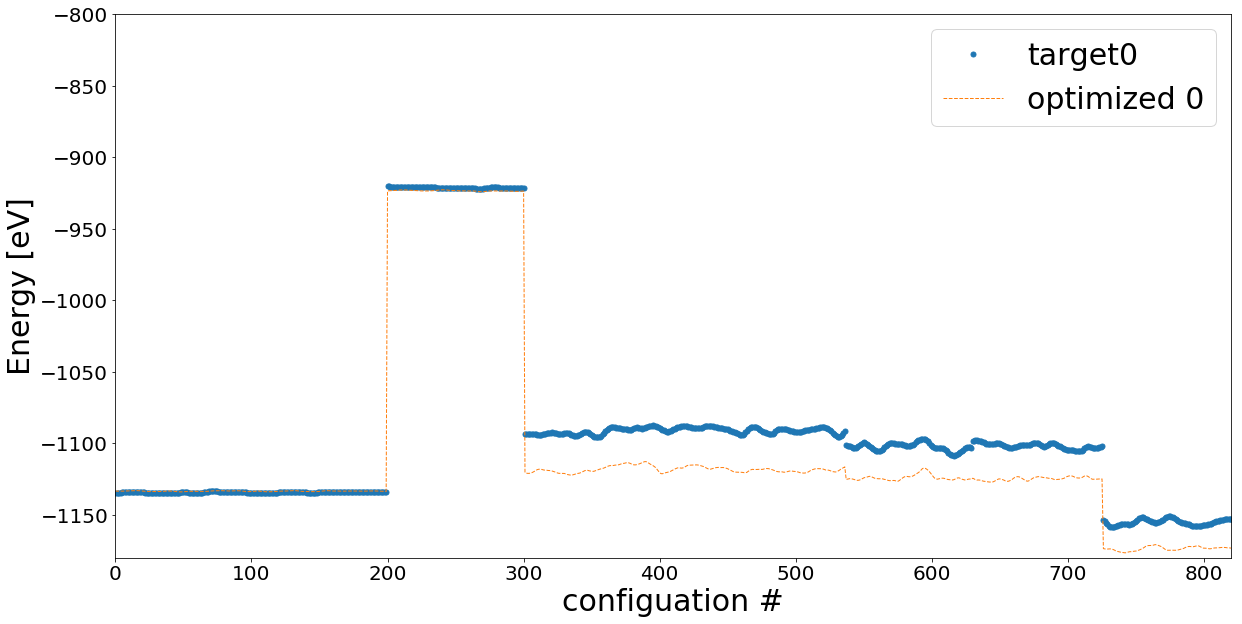

In [95]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[9])
    #plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=5)

        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 1:# and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]', fontsize=30)
plt.xlabel('configuation #', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

#plt.ylim(-1075,-1035)
#plt.ylim(-1000,-900)
#plt.ylim(-950,-900)
#plt.ylim(-1136,-1133)
plt.ylim(-1180,-800)
plt.xlim(0,820)
#plt.xlim(847,990)

#plt.ylim(-1180,-800)

plt.legend(fontsize=30)
plt.savefig(plt.savefig(os.path.join(working, 'bcc_300.png')))

In [120]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 4.407570269501649e-05 
 [-1.21658318, 3.2486358e-05, -47.3661687, 22.9965951, -3.42248343, 3.7395698, -1.39292737, -0.833458565, 0.929769431, -0.183568989]
1 6.17447812420396e-05 
 [-1.30551487, 1.41920657e-05, -46.1160967, 22.9352328, -3.42360958, 3.82313395, -1.54715703, -0.697925842, 0.868730239, -0.154592379]
2 9.723561709685708e-05 
 [-1.34624502, 7.49457487e-06, -45.8871674, 22.4064873, -3.46516902, 4.0226376, -1.8966168, -0.431617423, 0.806406324, -0.137562101]
3 0.00014123622250142564 
 [-1.34136558, 1.01769934e-05, -49.3998032, 22.1279115, -3.50791272, 4.16822104, -2.13414308, -0.266237999, 0.783819577, -0.136703203]


In [122]:
stats_opts[it]['hyperparams']

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [123]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[1]]

In [124]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [125]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [126]:
optimal_list

[{'pair_nodes': [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
  'mb_node': 6,
  'params': [(6.17447812420396e-05,
    [-1.30551487,
     1.41920657e-05,
     -46.1160967,
     22.9352328,
     -3.42360958,
     3.82313395,
     -1.54715703,
     -0.697925842,
     0.868730239,
     -0.154592379])]}]

In [127]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [128]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [129]:
optimal_list[-1]['params'][0][1]

[-1.30551487,
 1.41920657e-05,
 -46.1160967,
 22.9352328,
 -3.42360958,
 3.82313395,
 -1.54715703,
 -0.697925842,
 0.868730239,
 -0.154592379]

In [130]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [131]:
pair_y, many_y, V_x_r, rho_x_r

([-46.1160967,
  22.9352328,
  -3.42360958,
  3.82313395,
  -1.54715703,
  -0.697925842,
  0.868730239,
  -0.154592379],
 [-1.30551487, 0.0, 1.41920657e-05],
 [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
 [5.0])

In [132]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

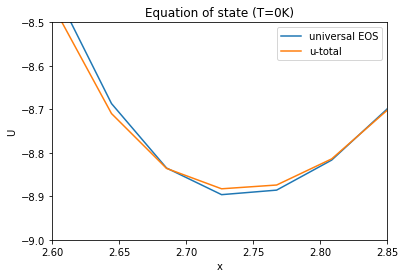

In [149]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.xlim(2.6, 2.85)
plt.ylim(-10,10)
plt.ylim(-9.,-8.5)

plt.xlabel('x')
plt.ylabel(r'U')

In [134]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [135]:
V_x_r

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [136]:
pair_a = optimal_list[-1]['params'][0][1][2:]#pars_in1[2:]
pair_r = optimal_list[-1]['pair_nodes']

rho_a = [1.0]
rho_r = [pair_r[optimal_list[-1]['mb_node']]]

par = optimal_list[-1]['params'][0][1][:2]
many_a = [par[0], 0.0, par[1]]

In [137]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 514.5


In [138]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [139]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [140]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lv_3.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))